## subtask 2.d) of homework 3

In [213]:
import numpy as np
import scipy.linalg

def solve_two_player_lqr(A, B1, B2, Q1, R1, Q2, R2, N,
                         S1, S2):
    """
    Solves a two-player Linear Quadratic Regulator (LQR) problem.

    Args:
        A (ndarray): System dynamics matrix.
        B1 (ndarray): Control input matrix for player 1.
        B2 (ndarray): Control input matrix for player 2.
        Q1 (ndarray): State cost matrix for player 1.
        R1 (ndarray): Control cost matrix for player 1.
        Q2 (ndarray): State cost matrix for player 2.
        R2 (ndarray): Control cost matrix for player 2.
        N (int): Time horizon for the finite-horizon LQR.

    Returns:
        H1 (list): state feedback for player 1 over the horizon.
        H2 (list): state feedback for player 2 over the horizon.
        P1 (list): Cost-to-go matrices for player 1 over the horizon.
        P2 (list): Cost-to-go matrices for player 2 over the horizon.
    """
    # Dimensions
    n = A.shape[0]  # State dimension
    m1 = B1.shape[1]  # Player 1 control dimension
    m2 = B2.shape[1]  # Player 2 control dimension

    # Initialize cost-to-go matrices (P matrices) for each player
    P1 = [None] * (N + 1)
    P2 = [None] * (N + 1)

    # Terminal conditions
    P1[N] = S1
    P2[N] = S2

    # value of game
    V = 0

    # Initialize action matrice U, V for all stages
    UV = np.zeros((N, m1+m2))

    # initialize feedback matrices H1, H2 for all staes
    H1 = np.zeros((N, m1, n))
    H2 = np.zeros((N, m2, n))

    # Backward recursion
    for t in range(N - 1, -1, -1):
        # compute inverse only once
        R1P1inv = np.linalg.inv(R1 + B1.T @ P1[t + 1] @ B1)
        R2P2inv = np.linalg.inv(R2 + B2.T @ P2[t + 1] @ B2)

        # build Psi matrix
        PSI = np.vstack((-R1P1inv @ B1.T @ P1[t + 1] @ A,
                        -R2P2inv @ B2.T @ P2[t + 1] @ A))
        
        # build PHI matrix (regressor)
        PHI = np.vstack((
            np.hstack((np.eye(m1), 
                    R1P1inv @ B1.T @ P1[t + 1] @ B2)),       
            np.hstack((R2P2inv @ B2.T @ P2[t + 1] @ B1, 
                    np.eye(m2)))
                    ))

        # compute H1, H2. note: uk = H1 @ xk, vk = H2 @ xk
        H = np.linalg.inv(PHI) @ PSI
        H1[t, :, :], H2[t, :, :] = H[:m1], H[m1:]

        # compute P1, P2
        P1[t] = Q1 + H1[t].T @ R1 @ H1[t] + (A + B1 @ H1[t] + B2 @ H2[t]).T @ P1[t + 1] @ (A + B1 @ H1[t] + B2 @ H2[t])
        P2[t] = Q2 + H2[t].T @ R2 @ H2[t] + (A + B1 @ H1[t] + B2 @ H2[t]).T @ P2[t + 1] @ (A + B1 @ H1[t] + B2 @ H2[t])

    return H1, H2, P1, P2


In [214]:
# if __name__ == "__main__":
# Define problem parameters
A = np.array([[1.0, 0], [0.0, 1.0]])
B1 = np.array([[1.0], [1.0]])
B2 = np.array([[1.0], [1.0]])
Q1 = np.array([[1.0, 0], [0.0, 0]])
R1 = np.eye(1)
Q2 = np.array([[0, 0], [0.0, 1.0]])
R2 = np.eye(1)
# terminal conditions
S1, S2 = Q1, Q2 
# number stages
N = 10

# Solve the two-player LQR problem
H1, H2, P1, P2 = solve_two_player_lqr(A, B1, B2, Q1, R1, Q2, R2, N,
                                        S1, S2)

    # Print the feedback gains
for t in range(N):
    print(f"Step {t}: K1 = {H1[t]}, K2 = {H2[t]}")

Step 0: K1 = [[-1.56744419  1.21202846]], K2 = [[ 1.21202846 -1.56744419]]
Step 1: K1 = [[-1.5580337   1.20261797]], K2 = [[ 1.20261797 -1.5580337 ]]
Step 2: K1 = [[-1.54343438  1.18801865]], K2 = [[ 1.18801865 -1.54343438]]
Step 3: K1 = [[-1.52078518  1.16536945]], K2 = [[ 1.16536945 -1.52078518]]
Step 4: K1 = [[-1.48564749  1.13023177]], K2 = [[ 1.13023177 -1.48564749]]
Step 5: K1 = [[-1.43113531  1.07571959]], K2 = [[ 1.07571959 -1.43113531]]
Step 6: K1 = [[-1.34656502  0.99114963]], K2 = [[ 0.99114963 -1.34656502]]
Step 7: K1 = [[-1.21533528  0.85993354]], K2 = [[ 0.85993354 -1.21533528]]
Step 8: K1 = [[-1.01075269  0.65591398]], K2 = [[ 0.65591398 -1.01075269]]
Step 9: K1 = [[-0.66666667  0.33333333]], K2 = [[ 0.33333333 -0.66666667]]


In [215]:
def solve_one_player_lqr(A, B, Q, R, N):
    """
    single-player lqr
    """
    # Dimensions
    n = A.shape[0]  # State dimension
    m = B.shape[1]  # Control dimension

    # Initialize cost-to-go matrices (P matrices)
    P = [None] * (N + 1)

    # Terminal condition
    P[N] = Q

    # Initialize gain matrices (K matrices)
    K = np.zeros((N, n, m))

    # Backward recursion to compute P and K
    for t in range(N - 1, -1, -1):
        # Intermediate matrices
        S = R + B.T @ P[t + 1] @ B
        Sinv = np.linalg.inv(S)
        F = B.T @ P[t + 1] @ A

        # Feedback gain matrix
        K[t] = -Sinv @ F

        # Update cost-to-go matrix
        # P[t] = Q + A.T @ P[t+1] @ A - A.T @ P[t+1] @ B @ K[t]
        # P[t] = Q + A.T @ (P[t + 1] - P[t+1] @ B @ S @ B @ P[t+1]) @ A  #K[t].T @ S @ K[t] + (A + B @ K[t]).T @ P[t + 1] @ (A + B @ K[t])
        P[t] = Q + A.T @ P[t + 1] @ A - A.T @ P[t + 1] @ B @ Sinv @ B.T @ P[t + 1] @ A

    return K, P

In [216]:
# Combine dynamics and costs for the single-player formulation
B = np.hstack((B1, B2))  # Combine control inputs
Q = Q1 + Q2  # Combine state costs
R = scipy.linalg.block_diag(R1, R2)  # Combine control costs

# Solve the single-player LQR problem
K, P = solve_one_player_lqr(A, B, Q, R, N)

In [217]:
def sim_2p_system(x0, A, B1, B2, H1, H2, N):
    n = A.shape[0]  # State dimension
    m1 = B1.shape[1]  # Player 1 control dimension
    m2 = B2.shape[1]  # Player 2 control dimension

    # Initialize state and control trajectories
    x = np.zeros((N + 1, n))
    u1 = np.zeros((N, m1))
    u2 = np.zeros((N, m2))

    # Initialize state
    x[0, :] = x0

    # Simulate the system
    for t in range(N):
        # Compute control inputs
        u1[t, :] = H1[t] @ x[t, :]
        u2[t, :] = H2[t] @ x[t, :]

        # Update state
        x[t + 1, :] = A @ x[t, :] + B1 @ u1[t, :] + B2 @ u2[t, :]

    return x, u1, u2

In [218]:
def sim_system(x0, A, B, K):
    """
    Simulates the system dynamics with a feedback controller.

    Args:
        x0 (ndarray): Initial state.
        A (ndarray): System dynamics matrix.
        B (ndarray): Control input matrix.
        K (list): List of state feedback matrices.

    Returns:
        x (ndarray): State trajectory.
        u (ndarray): Control input trajectory.
    """
    N = K.shape[0]  # Time horizon  
    n = A.shape[0]  # State dimension
    m = B.shape[1]  # Control dimension

    # Initialize state and control trajectories
    x = np.zeros((N + 1, n))
    u = np.zeros((N, m))

    # Initialize the state
    x[0, :] = x0

    # Simulate the system
    for t in range(N-1):
        u[t, :] = K[t] @ x[t, :]
        x[t + 1, :] = A @ x[t, :] + B @ u[t, :]

    return x, u

## price of anarychy

In [219]:
# plot price of anarchy for k=0,...,100
x0 = np.array([1/2, 1/2])

K = 100

PoA = np.zeros(K)
PoA[0] = 1
Xsp = [None] * K
Xsp[0] = x0
Xtp = [None] * K 
Xtp[0] = x0

# evolution of the state
for k in range(1, K):
    # solve lqr's
    Ks, Ps = solve_one_player_lqr(A, B, Q, R, k)
    H1, H2, P1, P2 = solve_two_player_lqr(A, B1, B2, Q1, R1, Q2, R2, k,
                                        S1, S2)
    

    # simulate systems
    x1, u11 = sim_system(x0, A, B, Ks)
    x2, u1, u2 = sim_2p_system(x0, A, B1, B2, H1, H2, k)
    Xsp[k] = x1
    Xtp[k] = x2

    # compute cost
    cost1 = np.sum([x.T @ Q @ x + u.T @ R @ u for x, u in zip(x1, u11)])
    cost2state = np.sum([x.T @ Q @ x for x in x2])
    cost2control = np.sum([u1k.T @ R1 @ u1k + u2k.T @ R2 @ u2k for u1k, u2k in zip(u1, u2)])
    cost2 = cost2state + cost2control
    
    PoA[k] = cost2/cost1


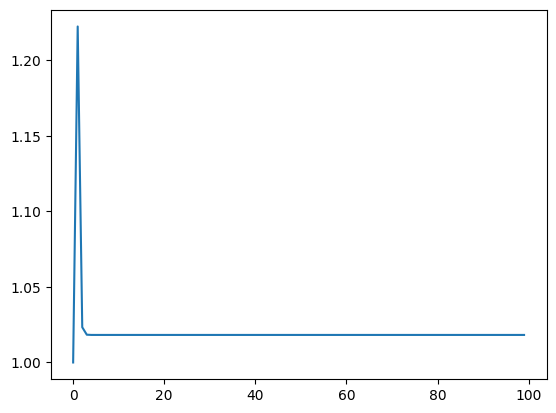

In [220]:
import matplotlib.pyplot as plt

plt.plot(PoA)